In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 10
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = bouncing_ball.InitBouncingBall(batch_shape=num_particles)

In [8]:
bouncing_ball_step = bouncing_ball.BouncingBallStep(batch_shape=num_particles)

In [9]:
def proposal_step():
    return bouncing_ball.ProposalStep(batch_shape=num_particles, name='BouncingBallStep')

In [10]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/0/init_bouncing_ball/position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_bouncing_ball = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    return mcmc.reduce_resample_move_smc(bouncing_ball_step, lambda: range(T), initializer=init_bouncing_ball)

In [18]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = bouncing_ball.InitBouncingBall(params=params, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [19]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = bouncing_ball.InitBouncingBall(params=generative_params, trainable=False,
                                                     batch_shape=num_particles)
    params['position_0']['loc'] = data['position_0']
    proposal_init = bouncing_ball.InitBouncingBall(params=params, trainable=False, batch_shape=num_particles)
    init_posterior = combinators.GuidedConditioning(generative_init, proposal_init)
    
    step_posterior = combinators.GuidedConditioning(bouncing_ball_step, step_proposal)
    
    return mcmc.reduce_resample_move_smc(step_posterior, lambda: range(T), initializer=init_posterior)

02/08/2019 17:45:51 EUBO=6.49876595e-01 at epoch 1
02/08/2019 17:45:52 EUBO=-1.20277891e+01 at epoch 2
02/08/2019 17:45:53 EUBO=-1.15672483e+01 at epoch 3
02/08/2019 17:45:54 EUBO=1.00450039e-01 at epoch 4
02/08/2019 17:45:55 EUBO=-1.12438869e+01 at epoch 5
02/08/2019 17:45:56 EUBO=4.26139832e-02 at epoch 6
02/08/2019 17:45:56 EUBO=9.67044830e-02 at epoch 7
02/08/2019 17:45:57 EUBO=-1.13373547e+01 at epoch 8
02/08/2019 17:45:58 EUBO=-1.23579206e+01 at epoch 9
02/08/2019 17:45:59 EUBO=-1.26129904e+01 at epoch 10
02/08/2019 17:46:00 EUBO=3.80364418e-01 at epoch 11
02/08/2019 17:46:00 EUBO=-1.28227320e+01 at epoch 12
02/08/2019 17:46:01 EUBO=-1.22461176e+01 at epoch 13
02/08/2019 17:46:02 EUBO=-1.25870638e+01 at epoch 14
02/08/2019 17:46:03 EUBO=-1.20146742e+01 at epoch 15
02/08/2019 17:46:04 EUBO=4.01617050e-01 at epoch 16
02/08/2019 17:46:05 EUBO=5.90599060e-01 at epoch 17
02/08/2019 17:46:05 EUBO=-1.23443499e+01 at epoch 18
02/08/2019 17:46:06 EUBO=2.34997272e-01 at epoch 19
02/08/2019

Epoch   251: reducing learning rate of group 0 to 5.0000e-02.


02/08/2019 17:49:20 EUBO=5.64680099e-01 at epoch 253
02/08/2019 17:49:21 EUBO=-1.18836870e+01 at epoch 254
02/08/2019 17:49:22 EUBO=1.64323807e-01 at epoch 255
02/08/2019 17:49:23 EUBO=-1.22386904e+01 at epoch 256
02/08/2019 17:49:24 EUBO=-1.24238272e+01 at epoch 257
02/08/2019 17:49:25 EUBO=3.85256767e-01 at epoch 258
02/08/2019 17:49:26 EUBO=-1.30063829e+01 at epoch 259
02/08/2019 17:49:26 EUBO=-1.25759401e+01 at epoch 260
02/08/2019 17:49:27 EUBO=-1.25887175e+01 at epoch 261
02/08/2019 17:49:28 EUBO=4.78734970e-01 at epoch 262
02/08/2019 17:49:29 EUBO=-1.20274706e+01 at epoch 263
02/08/2019 17:49:30 EUBO=-1.25736341e+01 at epoch 264
02/08/2019 17:49:31 EUBO=3.65889549e-01 at epoch 265
02/08/2019 17:49:31 EUBO=-1.12544861e+01 at epoch 266
02/08/2019 17:49:32 EUBO=2.35000610e-01 at epoch 267
02/08/2019 17:49:33 EUBO=-1.25071878e+01 at epoch 268
02/08/2019 17:49:34 EUBO=-1.18688822e+01 at epoch 269
02/08/2019 17:49:35 EUBO=-1.28075418e+01 at epoch 270
02/08/2019 17:49:36 EUBO=3.8959550

Epoch   452: reducing learning rate of group 0 to 2.5000e-02.


02/08/2019 17:52:09 EUBO=-1.22175493e+01 at epoch 454
02/08/2019 17:52:10 EUBO=-1.27831240e+01 at epoch 455
02/08/2019 17:52:11 EUBO=-1.29057322e+01 at epoch 456
02/08/2019 17:52:12 EUBO=4.55859184e-01 at epoch 457
02/08/2019 17:52:12 EUBO=-1.21361303e+01 at epoch 458
02/08/2019 17:52:13 EUBO=-1.27998171e+01 at epoch 459
02/08/2019 17:52:14 EUBO=-1.31621695e+01 at epoch 460
02/08/2019 17:52:15 EUBO=-1.26503267e+01 at epoch 461
02/08/2019 17:52:16 EUBO=4.10070896e-01 at epoch 462
02/08/2019 17:52:17 EUBO=-1.18537531e+01 at epoch 463
02/08/2019 17:52:17 EUBO=-1.24625845e+01 at epoch 464
02/08/2019 17:52:18 EUBO=6.44159794e-01 at epoch 465
02/08/2019 17:52:19 EUBO=-1.24256334e+01 at epoch 466
02/08/2019 17:52:20 EUBO=-1.22913561e+01 at epoch 467
02/08/2019 17:52:21 EUBO=5.34362793e-01 at epoch 468
02/08/2019 17:52:22 EUBO=3.19016933e-01 at epoch 469
02/08/2019 17:52:22 EUBO=-1.20770273e+01 at epoch 470
02/08/2019 17:52:23 EUBO=3.87275696e-01 at epoch 471
02/08/2019 17:52:24 EUBO=-1.057557

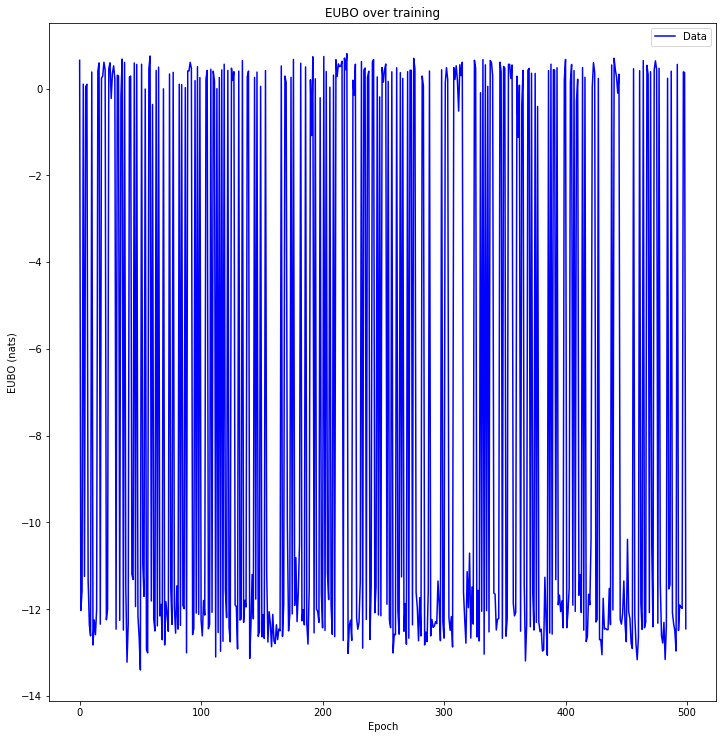

In [ ]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = combinators.GuidedConditioning(bouncing_ball_proposal, bouncing_ball_smc)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    _, inference, (positions, _, A_pred, final_mu, final_cov) = bouncing_ball_posterior(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

In [ ]:
graph_velocity_frequencies(modal_directions.detach())

In [ ]:
import bouncing_ball_plots

In [ ]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

In [ ]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [ ]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

In [ ]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)